In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 1000)
from bokeh.models import Panel, Tabs
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
import lightgbm as lgb
import plotly.figure_factory as ff
import gc
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

### What's the label of the training set?
I found that the red box of these three data, two are duplicate, there is another one, its input is the same as the other two, but the accuracy_group, I am a little confused, such a label is we should want to predict? Or do we just need to select one of the labels as the labels we need to predict?

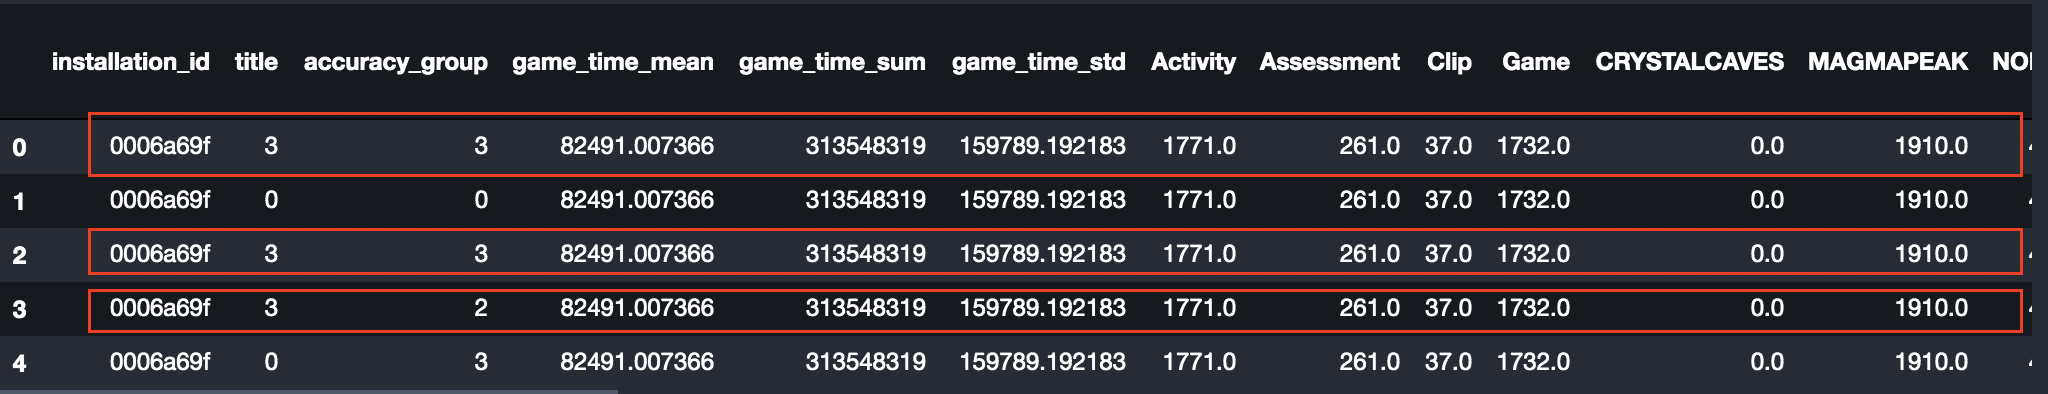

# Reading Files

In [ ]:
%%time
print('Reading train.csv file....')
train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

print('Reading test.csv file....')
test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

print('Reading train_labels.csv file....')
train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

print('Reading specs.csv file....')
specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

print('Reading sample_submission.csv file....')
sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))

### Start getting familiar with training set labels
after find out what we're going to predict from this great kernel, [The goal is not clear to me](https://www.kaggle.com/c/data-science-bowl-2019/discussion/114198#latest-659333)

When I try to get familiar with the labels of the training set,  i find that...


the code is from [Simple exploratory data analysis and model](https://www.kaggle.com/ragnar123/simple-exploratory-data-analysis-and-model)

In [ ]:
# funtions to get agg stadistics and merge with test and train
def get_object_columns(df, columns):
    df = df.groupby(['installation_id', columns])['event_id'].count().reset_index()
    df = df.pivot_table(index = 'installation_id', columns = [columns], values = 'event_id')
    df.columns = list(df.columns)
    df.fillna(0, inplace = True)
    return df

def get_numeric_columns(df, column):
    df = df.groupby('installation_id').agg({f'{column}': ['mean', 'sum', 'std']})
    df.fillna(0, inplace = True)
    df.columns = [f'{column}_mean', f'{column}_sum', f'{column}_std']
    return df

def get_numeric_columns_2(df, agg_column, column):
    df = df.groupby(['installation_id', agg_column]).agg({f'{column}': ['mean', 'sum', 'std']}).reset_index()
    df = df.pivot_table(index = 'installation_id', columns = [agg_column], values = [col for col in df.columns if col not in ['installation_id', 'type']])
    df.fillna(0, inplace = True)
    df.columns = list(df.columns)
    return df

numerical_columns = ['game_time']
categorical_columns = ['type', 'world']

reduce_train = pd.DataFrame({'installation_id': train['installation_id'].unique()})
reduce_train.set_index('installation_id', inplace = True)
reduce_test = pd.DataFrame({'installation_id': test['installation_id'].unique()})
reduce_test.set_index('installation_id', inplace = True)

# train = get_time(train)

for i in numerical_columns:
    reduce_train = reduce_train.merge(get_numeric_columns(train, i), left_index = True, right_index = True)
    reduce_test = reduce_test.merge(get_numeric_columns(test, i), left_index = True, right_index = True)
    
for i in categorical_columns:
    reduce_train = reduce_train.merge(get_object_columns(train, i), left_index = True, right_index = True)
    reduce_test = reduce_test.merge(get_object_columns(test, i), left_index = True, right_index = True)
    
for i in categorical_columns:
    for j in numerical_columns:
        reduce_train = reduce_train.merge(get_numeric_columns_2(train, i, j), left_index = True, right_index = True)
        reduce_test = reduce_test.merge(get_numeric_columns_2(test, i, j), left_index = True, right_index = True)
    
    
reduce_train.reset_index(inplace = True)
reduce_test.reset_index(inplace = True)
    
print('Our training set have {} rows and {} columns'.format(reduce_train.shape[0], reduce_train.shape[1]))
    
# get the mode of the title
labels_map = dict(train_labels.groupby('title')['accuracy_group'].agg(lambda x:x.value_counts().index[0]))
# merge target
labels = train_labels[['installation_id', 'title', 'accuracy_group']]
# replace title with the mode
labels['title'] = labels['title'].map(labels_map)
# get title from the test set
reduce_test['title'] = test.groupby('installation_id').last()['title'].map(labels_map).reset_index(drop = True)
# join train with labels
reduce_train = labels.merge(reduce_train, on = 'installation_id', how = 'left')
print('We have {} training rows'.format(reduce_train.shape[0]))

In [ ]:
reduce_train.head()

In [ ]:
train_labels.query('installation_id=="0006a69f"')

In [ ]:
reduce_train.query('installation_id=="0006a69f"')

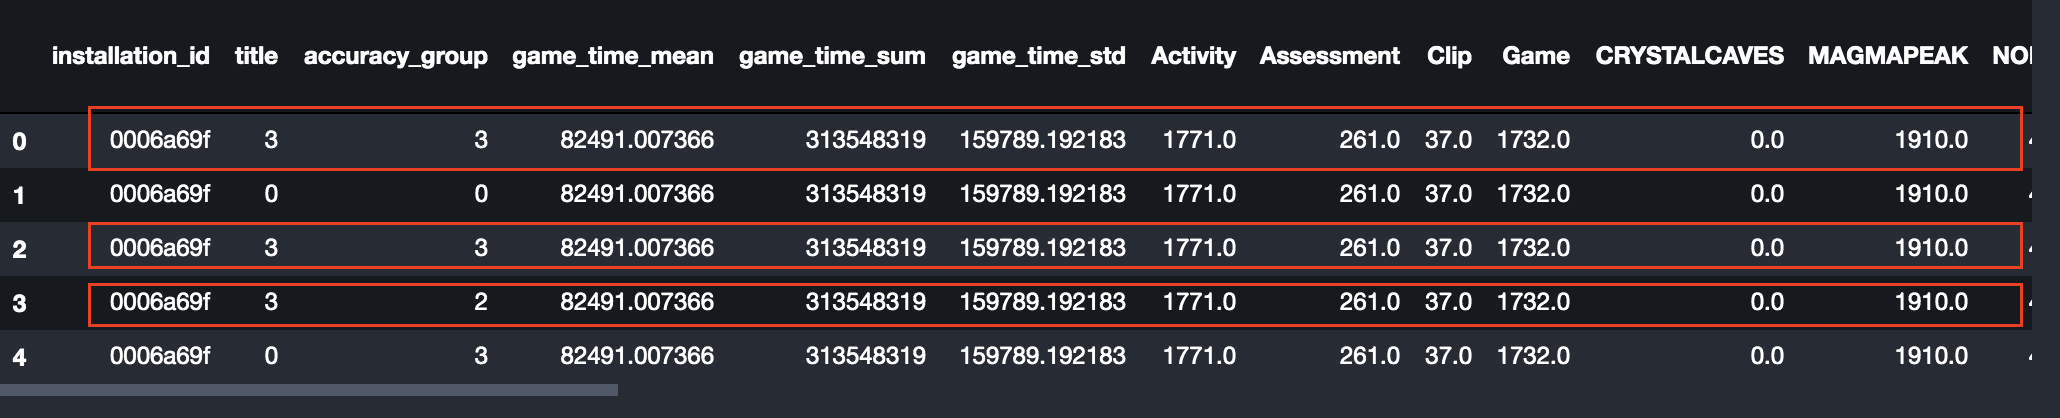

### What's the label of the training set?
I found that the red box of these three data, two are duplicate, there is another one, its input is the same as the other two, but the accuracy_group, I am a little confused, such a label is we should want to predict? Or do we just need to select one of the labels as the labels we need to predict?